In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Well some of the columns has the missing values. So I filled them mode of the respective columns.
Further there were several categorize labels, which were actually 'object' type.
I converted 'object' dtype to 'int' type manually using map()

In [4]:
df['Gender'] = df['Gender'].fillna( df['Gender'].dropna().mode().values[0] )
df['Married'] = df['Married'].fillna( df['Married'].dropna().mode().values[0] )
df['Dependents'] = df['Dependents'].fillna( df['Dependents'].dropna().mode().values[0] )
df['Self_Employed'] = df['Self_Employed'].fillna( df['Self_Employed'].dropna().mode().values[0] )
df['LoanAmount'] = df['LoanAmount'].fillna( df['LoanAmount'].dropna().mean() )
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna( df['Loan_Amount_Term'].dropna().mode().values[0] )
df['Credit_History'] = df['Credit_History'].fillna( df['Credit_History'].dropna().mode().values[0] )
df['Dependents'] = df['Dependents'].str.rstrip('+')
df['Gender'] = df['Gender'].map({'Female':0,'Male':1}).astype(np.int)
df['Married'] = df['Married'].map({'No':0, 'Yes':1}).astype(np.int)
df['Education'] = df['Education'].map({'Not Graduate':0, 'Graduate':1}).astype(np.int)
df['Self_Employed'] = df['Self_Employed'].map({'No':0, 'Yes':1}).astype(np.int)
df['Loan_Status'] = df['Loan_Status'].map({'N':0, 'Y':1}).astype(np.int)
df['Dependents'] = df['Dependents'].astype(np.int)

In [5]:
df.dtypes

Loan_ID               object
Gender                 int32
Married                int32
Dependents             int32
Education              int32
Self_Employed          int32
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status            int32
dtype: object

Dividing the given train dataset in the form of features and target variables and further making use of get_dummies from pandas library

In [6]:
X,y  = df.iloc[:, 1:-1], df.iloc[:, -1]

In [8]:
X= pd.get_dummies(X)

In [81]:
dtrain= pd.get_dummies(df)
import xgboost as xgb
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV 
train = dtrain
target = 'Loan_Status'
IDcol = 'Loan_ID'

C:\Users\Architect_shwet\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# I defined a function which will help us to create xgboost models and perform cross validation

In [82]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Loan_Status'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Loan_Status'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Loan_Status'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9186
AUC Score (Train): 0.984918


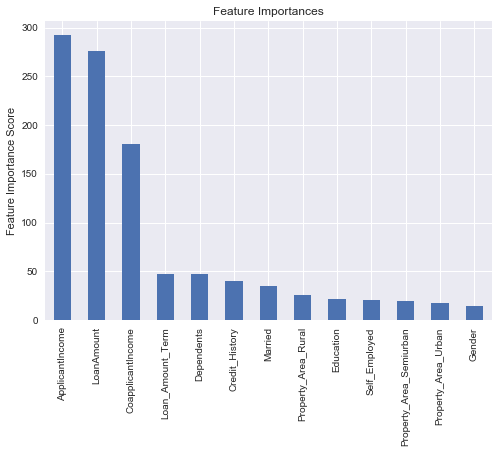

In [97]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb2, train, predictors)

# Parameter Tuning For XGBoost model
Parameter tuning like learning rate, some tree specific parameters like max_depth, min_child_weight, gamma, subsample, colsample_bytree.
Keeping all the parameters initially fixed, with the use of grid search :
Tuning max_depth and min_child_weight

In [89]:
param_test1 = { 'max_depth':list(range(3,10,2)), 'min_child_weight':list(range(1,6,2))}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.74538, std: 0.04629, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.75191, std: 0.04508, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.75320, std: 0.03758, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.74620, std: 0.04597, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.75153, std: 0.04587, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.75271, std: 0.04045, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.75128, std: 0.04208, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.74546, std: 0.05205, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.75243, std: 0.04625, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.74995, std: 0.03917, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.74883, std: 0.04849, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.75656, std: 0.04573, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_child_weight': 5

In [88]:
param_test2 = { 'max_depth':[8,9,10], 'min_child_weight':[4,5,6] }
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.75185, std: 0.04845, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.75578, std: 0.04642, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.75804, std: 0.04415, params: {'max_depth': 8, 'min_child_weight': 6},
  mean: 0.75014, std: 0.04887, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: 0.75656, std: 0.04573, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: 0.75804, std: 0.04415, params: {'max_depth': 9, 'min_child_weight': 6},
  mean: 0.75115, std: 0.04894, params: {'max_depth': 10, 'min_child_weight': 4},
  mean: 0.75656, std: 0.04573, params: {'max_depth': 10, 'min_child_weight': 5},
  mean: 0.75804, std: 0.04415, params: {'max_depth': 10, 'min_child_weight': 6}],
 {'max_depth': 8, 'min_child_weight': 6},
 0.7580432415881333)

In [90]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

([mean: 0.75804, std: 0.04415, params: {'min_child_weight': 6},
  mean: 0.75407, std: 0.03464, params: {'min_child_weight': 8},
  mean: 0.75503, std: 0.03964, params: {'min_child_weight': 10},
  mean: 0.75517, std: 0.03951, params: {'min_child_weight': 12}],
 {'min_child_weight': 6},
 0.7580432415881333)

In [91]:
param_test2c = {
 'min_child_weight':[6,7]
}
gsearch2c = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2c.fit(train[predictors],train[target])
gsearch2c.grid_scores_, gsearch2c.best_params_, gsearch2c.best_score_

([mean: 0.75804, std: 0.04415, params: {'min_child_weight': 6},
  mean: 0.75407, std: 0.03464, params: {'min_child_weight': 8},
  mean: 0.75503, std: 0.03964, params: {'min_child_weight': 10},
  mean: 0.75517, std: 0.03951, params: {'min_child_weight': 12}],
 {'min_child_weight': 6},
 0.7580432415881333)

# Tuning Gamma

In [92]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.75804, std: 0.04415, params: {'gamma': 0.0},
  mean: 0.75831, std: 0.04431, params: {'gamma': 0.1},
  mean: 0.75667, std: 0.04149, params: {'gamma': 0.2},
  mean: 0.75260, std: 0.04321, params: {'gamma': 0.3},
  mean: 0.75780, std: 0.04605, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 0.7583149049093322)


Model Report
Accuracy : 0.8632
AUC Score (Train): 0.944152


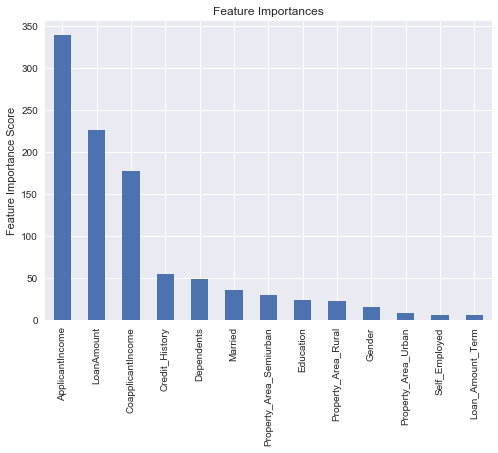

In [98]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.9,
                     colsample_bytree=0.95,reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb2, train, predictors)

# Tuning subsample and colsample_bytree

In [123]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.74927, std: 0.04252, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.74761, std: 0.04192, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.74978, std: 0.04527, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.75374, std: 0.04096, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.75373, std: 0.03959, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.75229, std: 0.03935, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.75455, std: 0.04106, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.75439, std: 0.04098, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.75165, std: 0.04236, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.75167, std: 0.04022, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.75698, std: 0.04308, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.75781, std: 0.04062, params: {'colsample_bytree': 0.8, 'subsample'

In [124]:
param_test4a = {
 'subsample':[i/10.0 for i in range(9,12)],
 'colsample_bytree':[i/10.0 for i in range(9,12)]
}
gsearch4a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.74927, std: 0.04252, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.74761, std: 0.04192, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.74978, std: 0.04527, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.75374, std: 0.04096, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.75373, std: 0.03959, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.75229, std: 0.03935, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.75455, std: 0.04106, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.75439, std: 0.04098, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.75165, std: 0.04236, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.75167, std: 0.04022, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.75698, std: 0.04308, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.75781, std: 0.04062, params: {'colsample_bytree': 0.8, 'subsample'

In [125]:
param_test5 = {
 'subsample':[i/100.0 for i in range(95,105,5)],
 'colsample_bytree':[i/100.0 for i in range(95,105,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.76148, std: 0.04423, params: {'colsample_bytree': 0.95, 'subsample': 0.95},
  mean: 0.76646, std: 0.04266, params: {'colsample_bytree': 0.95, 'subsample': 1.0},
  mean: 0.76595, std: 0.03866, params: {'colsample_bytree': 1.0, 'subsample': 0.95},
  mean: 0.76371, std: 0.04567, params: {'colsample_bytree': 1.0, 'subsample': 1.0}],
 {'colsample_bytree': 0.95, 'subsample': 1.0},
 0.7664622529173613)

# Tuning reg_alpha

In [127]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0.1, subsample=0.95, colsample_bytree=0.95,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.76148, std: 0.04423, params: {'reg_alpha': 1e-05},
  mean: 0.75951, std: 0.04004, params: {'reg_alpha': 0.01},
  mean: 0.76291, std: 0.04174, params: {'reg_alpha': 0.1},
  mean: 0.76493, std: 0.03972, params: {'reg_alpha': 1},
  mean: 0.70554, std: 0.04776, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.7649282709035032)

In [ ]:
param_test6a = {
 'reg_alpha':[1,2,3,4,5]
}
gsearch6a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0.1, subsample=0.95, colsample_bytree=0.95,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6a, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6a.fit(train[predictors],train[target])
gsearch6a.grid_scores_, gsearch6a.best_params_, gsearch6a.best_score_

In [ ]:

xgb3 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.95,
                     colsample_bytree=0.95, reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb3, train, predictors)

Features on larger scales can unduly influence the model. We want features on a similar scale. Scikit's preprocessing provides us with StandardScaler package to scale our data.

In [106]:
from sklearn.preprocessing import StandardScaler
slc= StandardScaler()
X_train_std = slc.fit_transform(X)

# Applying machine learning models
 Using RandomForestClassifier with the parameters

In [107]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators =400, criterion='entropy', oob_score=True, random_state=1,n_jobs=-1)

Using the above function of different XGBoost models and with grid search-cross validation, I found the effective value of each of the parameters

In [108]:
from xgboost.sklearn import XGBClassifier
#xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.95,
                     #colsample_bytree=0.95, reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
xgb1=XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.9,
                     colsample_bytree=0.95,reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [109]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=0)

# Voting Classifier
I used VotingClassifier which will fit clones of those original estimators.

In [110]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('forest', forest), ('xgb', xgb1), ('adaboost', ada)], voting='hard')

In [111]:
eclf.fit(X_train_std, y)

VotingClassifier(estimators=[('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
       ...andom_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=500, random_state=0))],
         n_jobs=1, voting='hard', weights=None)

In [112]:
dtest = pd.read_csv('test_Y3wMUE5_7gLdaTN.csv')

# Similar approach is done on the competition given test data.

In [113]:
dtest['Gender'] = dtest['Gender'].map({'Female':0,'Male':1})
dtest['Married'] = dtest['Married'].map({'No':0, 'Yes':1}).astype(np.int)
dtest['Education'] = dtest['Education'].map({'Not Graduate':0, 'Graduate':1}).astype(np.int)
dtest['Self_Employed'] = dtest['Self_Employed'].map({'No':0, 'Yes':1})
dtest['Dependents'] = dtest['Dependents'].str.rstrip('+')
dtest['Gender'] = dtest['Gender'].fillna( dtest['Gender'].dropna().mode().values[0]).astype(np.int)
dtest['Dependents'] = dtest['Dependents'].fillna( dtest['Dependents'].dropna().mode().values[0]).astype(np.int)
dtest['Self_Employed'] = dtest['Self_Employed'].fillna( dtest['Self_Employed'].dropna().mode().values[0])
dtest['LoanAmount'] = dtest['LoanAmount'].fillna( dtest['LoanAmount'].dropna().mode().values[0])
dtest['Loan_Amount_Term'] = dtest['Loan_Amount_Term'].fillna( dtest['Loan_Amount_Term'].dropna().mode().values[0])
dtest['Credit_History'] = dtest['Credit_History'].fillna( dtest['Credit_History'].dropna().mode().values[0] )

In [114]:

X_test = dtest.iloc[:,1:]

In [115]:
X_test= pd.get_dummies(X_test)

In [116]:
X_test_std = slc.transform(X_test)

 Predicting on the unseen dataset(test) using the voting classifier model

In [117]:

y_test_pred = eclf.predict(X_test_std)

In [118]:
dtest['Loan_Status'] = y_test_pred
df_final = dtest.drop(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area'], axis=1)

In [119]:
df_final['Loan_Status'] = df_final['Loan_Status'].map({0:'N', 1:'Y'})

In [120]:
df_final.to_csv('loan prediction.csv', index=False)

In [121]:
df_final.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
